<a href="https://colab.research.google.com/github/mar7i4ka/Neural-Networks/blob/main/OneLayerNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Използване на един универсален неврон, който чрез контекстно превключване емулира цяла невронна мрежа. Тук се обработва цял слой наведнъж вместно неврон по неврон. Умножавам матрицата от входа с теглата по входа с изображенията и с Numpy и симулирам цял слой изчисл

Using device: cpu
Epoch 1, Loss: 324.9721
Epoch 2, Loss: 132.9758
Epoch 3, Loss: 89.6377
Epoch 4, Loss: 67.5795
Epoch 5, Loss: 51.8959
Context-Switching Accuracy (1 physical layer): 97.44%


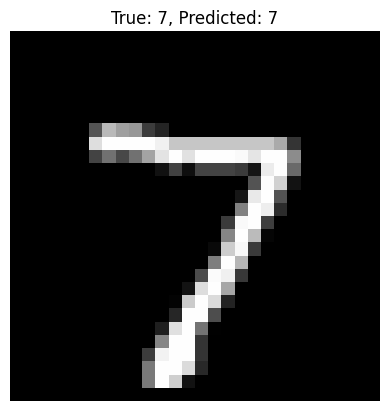

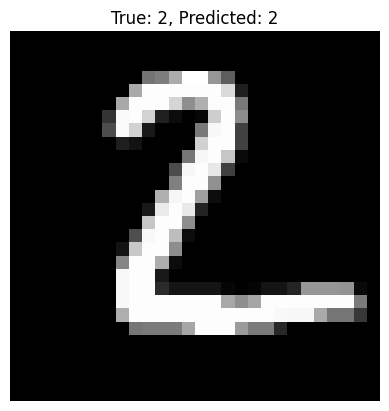

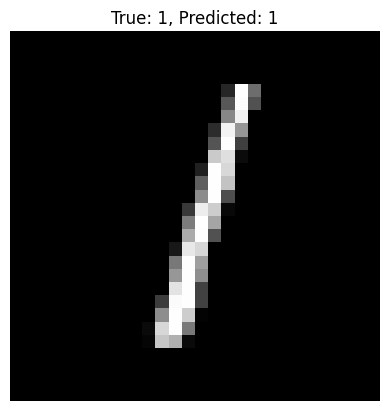

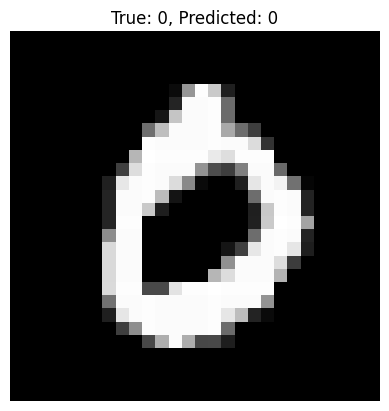

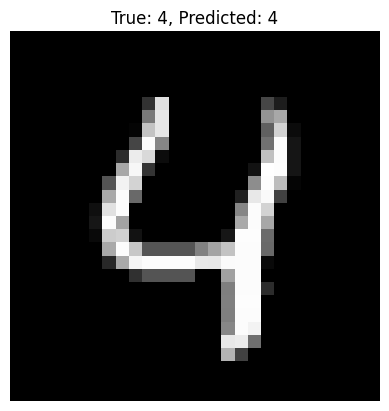

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Мрежа
class MultiLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() #turn each image of MNIST from 28x28(2D) into 1D vector of 784 pixels
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) #10 beacuse we are looking for numbers from 0-9
        self.act = nn.ReLU() #act. func - 0 if the output is negative

    def forward(self, x):
        x = self.flatten(x) #convert from 1 28 28 to 1 784
        x = self.act(self.fc1(x)) #apply 1st layer and ReLU
        x = self.act(self.fc2(x)) #apply second layer and ReLU
        x = self.fc3(x) #output 10 values before softmax
        return x

# Зареждане на MNIST
transform = transforms.Compose([transforms.ToTensor()]) #convert images to tensors, normalize the pixels
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True) #split in batches of 64 images and shuffle them so the model doesnt'learn them in a fixed ordeer (WHY?)
'''
shuffling is important to reduse bias(early batches will contin similar looking digits, might overfit 0 and 1 and then struggle later on 8 and 9),
reduce generalization ( do well on new data), faster leariing beacuse diff inf in every batch
'''
# Обучение
model = MultiLayerNet().to(device) #start the learning
criterion = nn.CrossEntropyLoss() #loss function - compare predicted values to true labels
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer to adjust w during learning. Using adaptive moment estimation. Learning rate is small

for epoch in range(5):
    model.train()
    total_loss = 0 #measure loss
    for images, labels in train_loader: #loop through the dataset in batches
        images, labels = images.to(device), labels.to(device) #move the data to the device
        outputs = model(images) #pass through the model
        loss = criterion(outputs, labels) #calculate loss

        optimizer.zero_grad() #clear any previous gradient stored
        loss.backward() #calculate gradients (how much each weight contributed to the error(loss))
        optimizer.step() #update model weights uding the calc gradients

        total_loss += loss.item() #add loss to total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Извличане на тегла и bias-и
def extract_contexts(model):
    return [
        (model.fc1.weight.detach().cpu().numpy(), model.fc1.bias.detach().cpu().numpy()), #.cpu(move from gpu to cpu), .numpy from tensor to np array
        (model.fc2.weight.detach().cpu().numpy(), model.fc2.bias.detach().cpu().numpy()),
        (model.fc3.weight.detach().cpu().numpy(), model.fc3.bias.detach().cpu().numpy())
    ]

# 5. ReLU LUT таблица - precompute values in the table so relu wont need to be called every time and the table will just be an input table
relu_lut_resolution = 1000 #can eb changed to more but this is enough to store 0.02 units of input to the lut table
x_vals = np.linspace(-10, 10, relu_lut_resolution) #1D array in 1000 steps from -10 to 10
relu_vals = np.maximum(0, x_vals) #apply relu to each values negative to 0 positive stay the same

def relu_lut(x):
    x = np.clip(x, -10, 10) #make sure x stays in range
    idx = int(((x + 10) / 20) * (relu_lut_resolution - 1)) #change resolution to start from 0, make all values int
    return relu_vals[idx]


# Еднослойна мрежа

def simulate_layer(input_vector, weights, bias, use_activation=True):
    z = np.dot(weights, input_vector) + bias #matrix multiplication - z is the raw outup before activation
    if use_activation:
        return np.array([relu_lut(v) for v in z]) #
    else:
        return z  # Last layer, no activation


# Forward pass

def context_switch_inference(img, context_list):
    x = img.view(-1).numpy() #vecor

    for i, (w, b) in enumerate(context_list):
        use_act = (i < len(context_list) - 1)  # no activation after last layer
        x = simulate_layer(x, w, b, use_activation=use_act)

    return np.argmax(x)

# Тестване

def test_context_switching(model, test_data):
    context_list = extract_contexts(model)
    correct = 0

    for i in range(len(test_data)):
        img, label = test_data[i]
        pred = context_switch_inference(img, context_list)
        correct += (pred == label)

    acc = 100 * correct / len(test_data)
    print(f"Context-Switching Accuracy (1 physical layer): {acc:.2f}%")

test_context_switching(model, test_data)

# Визуализация
def visualize_predictions(test_data, context_list, count=5):
    for i in range(count):
        img, label = test_data[i]
        pred = context_switch_inference(img, context_list)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {label}, Predicted: {pred}")
        plt.axis('off')
        plt.show()

context_list = extract_contexts(model)
visualize_predictions(test_data, context_list, count=5)

In [ ]:
from sklearn.metrics import classification_report, top_k_accuracy_score
import seaborn as sns
import time

def extended_evaluation(model, test_data):
    context_list = extract_contexts(model)
    y_true = []
    y_pred = []
    y_scores = []

    total_time = 0
    nonzero_activation_count = 0
    total_activation_count = 0

    for i in range(len(test_data)):
        img, label = test_data[i]
        y_true.append(label)

        #Measure inference time
        start_time = time.time()
        x = img.view(-1).numpy()
        for j, (w, b) in enumerate(context_list):
            use_act = (j < len(context_list) - 1)
            z = np.dot(w, x) + b
            if use_act:
                activated = np.array([relu_lut(val) for val in z])
                nonzero_activation_count += np.count_nonzero(activated)
                total_activation_count += len(activated)
                x = activated
            else:
                x = z  #Last layer output
        total_time += time.time() - start_time

        y_pred.append(np.argmax(x))
        y_scores.append(x)  #store full output

    acc = 100 * np.mean(np.array(y_pred) == np.array(y_true))
    top3_acc = 100 * top_k_accuracy_score(y_true, y_scores, k=3, labels=list(range(10)))

    print(f"\n🔍 Extended Evaluation Metrics")
    print(f"Top-1 Accuracy: {acc:.2f}%")
    print(f"Top-3 Accuracy: {top3_acc:.2f}%")
    print(f"Average Inference Time: {1000 * total_time / len(test_data):.4f} ms/sample")

    if total_activation_count > 0:
        sparsity = 100 * (1 - nonzero_activation_count / total_activation_count)
        print(f"Activation Sparsity (ReLU zero output %): {sparsity:.2f}%")

#Report

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

extended_evaluation(model, test_data)



🔍 Extended Evaluation Metrics
Top-1 Accuracy: 97.44%
Top-3 Accuracy: 99.68%
Average Inference Time: 1.5353 ms/sample
Activation Sparsity (ReLU zero output %): 47.17%

Classification Report:
              precision    recall  f1-score   support

           0     0.9749    0.9898    0.9823       980
           1     0.9843    0.9938    0.9890      1135
           2     0.9749    0.9777    0.9763      1032
           3     0.9878    0.9634    0.9754      1010
           4     0.9845    0.9674    0.9759       982
           5     0.9473    0.9865    0.9665       892
           6     0.9781    0.9791    0.9786       958
           7     0.9728    0.9747    0.9738      1028
           8     0.9838    0.9374    0.9600       974
           9     0.9543    0.9722    0.9632      1009

    accuracy                         0.9744     10000
   macro avg     0.9743    0.9742    0.9741     10000
weighted avg     0.9746    0.9744    0.9744     10000

